In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# US Adidas sales

### 1. The Context
The U.S. market is a pivotal arena for global sports brands like Adidas. Analyzing sales data within this region offers crucial insights into consumer preferences and market dynamics. This study aims to dissect Adidas's sales across various U.S. regions, focusing on identifying areas of strength and opportunities for growth.

### 2. The Objective
The primary goal is to conduct a detailed analysis of Adidas's sales data in the U.S. This involves:
- **Exploratory Data Analysis (EDA)**: Understanding the patterns and anomalies in the sales data.
- **Geo-Spatial Analysis**: Utilizing geo-spatial tools to visualize and interpret sales across different geographic segments (regions, states, cities).

### 3. The Key Questions
- How do sales figures and patterns differ across various U.S. regions, states, and cities?
- What trends emerge from a geo-spatial analysis of the sales data?

### 4. The Problem Formulation
This project aims to uncover the underlying dynamics of Adidas's sales performance across the U.S., identifying high-performing areas and those needing improvement. The insights gained will guide strategic decisions and marketing efforts to bolster Adidas's presence in the U.S. market.

## Table of contents
- [Data cleaning](#Data-cleaning)
- [Data cleaning summary](#Data-cleaning-summary)
- [Analysis](#Analysis)
- [Analysis summary](#analysis-summary)
- [Insights and conclusion](#Insights-and-conclusion)

### Data Dictionary

| Column            | Data Type | Description                                                       |
|-------------------|-----------|-------------------------------------------------------------------|
| Retailer          | object    | The name of the retailer that sells Adidas products.              |
| Retailer ID       | int       | A unique ID for each retailer.                                    |
| Invoice Date      | object    | The date of the sales transaction.                                |
| Region            | object    | The geographic area where the sale occurs.                        |
| State             | object    | The state where the sale occurred.                                |
| City              | object    | The city where the sale occurred.                                 |
| Product           | object    | The category of the product being sold.                           |
| Price per Unit    | float     | The unit price of the product.                                    |
| Units Sold        | int       | The number of units of the product sold.                          |
| Total Sales       | float     | Total revenue from the product sale.                              |
| Operating Profit  | float     | The profit generated from the product sale.                       |
| Operating Margin  | float     | The percentage of profit generated from the sale of the product.  |
| Sales Method      | object    | The method of sale used by retailers (Online/In-store/Outlet).    |

In [2]:
# Data manipulation and formatting
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
np.set_printoptions(suppress=True)
# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
# Statistics
import scipy.stats as stats
import statsmodels.api as sm
np.set_printoptions(suppress=True)

In [3]:
sales =  pd.read_csv("/Users/moiezismail/projects/adidas sales/adidas_csv_master.csv")

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        0 non-null      float64
 1   Retailer          9648 non-null   object 
 2   Retailer ID       9648 non-null   int64  
 3   Invoice Date      9648 non-null   object 
 4   Region            9648 non-null   object 
 5   State             9648 non-null   object 
 6   City              9648 non-null   object 
 7   Product           9648 non-null   object 
 8   Price per Unit    9648 non-null   object 
 9   Units Sold        9648 non-null   object 
 10  Total Sales       9648 non-null   object 
 11  Operating Profit  9648 non-null   object 
 12  Operating Margin  9648 non-null   object 
 13  Sales Method      9648 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.0+ MB


In [5]:
sales.sample(3)

,Unnamed: 0,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
6878,NaN,Sports Direct,1185732,8/9/2021,Midwest,North Dakota,Fargo,Women's Apparel,$54.00,95,"$5,130","$2,719",53%,Online
8599,NaN,West Gear,1185732,7/10/2021,West,Utah,Salt Lake City,Men's Apparel,$28.00,140,"$3,920","$1,490",38%,Outlet
1442,NaN,West Gear,1185732,2/10/2021,Northeast,New York,Albany,Women's Apparel,$45.00,650,"$292,500","$146,250",50%,In-store


#### Initial observations: 
1. need to convert object d-types to numerical in order to get statistics and perform analysis
2. The data is one table but can split into two tables, one for order information, and one for store information for storage and quering in GCP. We'll used the cleaned sales table to perform analysis, visualizaiton, and predictive modeling. 
3. We can get a variety of different insights and visualizations because there is geographic, categorical, and numeric data.
4. The target variable in question is "Total sales" as that describes a store's overall performance, the task is to find what features of the store are most important in predicting that value.

## Data cleaning

In [6]:
#Drop the unnamed column
sales.drop(columns=["Unnamed: 0"], inplace=True)

# Columns to convert from currency format to float
currency_cols = ['Total Sales', 'Operating Profit', 'Price per Unit']

# Remove dollar signs and commas, then convert to float
for col in currency_cols:
    sales[col] = sales[col].str.replace(
        '$', '',regex=False).str.replace(
        ',','', regex=False).astype(float)

# Remove percentage signs from 'Operating Margin', then convert to int
sales["Operating Margin"] = sales["Operating Margin"].str.replace('%', '', regex=False).astype(int)
# Remove commas from 'Units Sold' and convert to int`
sales['Units Sold'] = sales['Units Sold'].str.replace(',', '', regex=False).astype(int)
# Convert 'Invoice Date' to datetime format of yyyy-mm-dd
sales["Invoice Date"] = pd.to_datetime(sales['Invoice Date'])
#Rename columns
sales= sales.rename(columns={
    'Operating Profit':'Oper_prof',
    'Price per Unit':'Price',
    'Invoice Date':'Invoice_date',
    'Units Sold':'units_sold', 
    'Total Sales':'Sales',
    'Retailer ID':'Retailer_ID',
    'Operating Margin':'sales_marg',
    'Sales Method':'Method'})

In [7]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Product,Price,units_sold,Sales,Oper_prof,sales_marg,Method
9315,Sports Direct,1185732,2021-07-03,Northeast,Connecticut,Hartford,Men's Street Footwear,42.00,195,8190.00,3686.00,45,Outlet
712,West Gear,1128299,2020-08-02,West,Washington,Seattle,Women's Street Footwear,80.00,550,440000.00,110000.00,25,In-store
3532,Sports Direct,1185732,2021-03-03,Northeast,Connecticut,Hartford,Men's Athletic Footwear,40.00,225,90000.00,36000.00,40,In-store


#### Change float dtype to integer

In [8]:
sales[['Sales','Price', 'Oper_prof']] = sales[[
    'Sales','Price', 'Oper_prof']].astype(int)

In [9]:
# Check if the total sales are indeed units sold x price per unit in the 'sales' DataFrame
sales['Sales_match'] = sales[
    'Sales'] == sales['units_sold'] * sales[
    'Price']
sales['Sales_match'].value_counts()

True     5762
False    3886
Name: Sales_match, dtype: int64

#### Observation: 
- Total sales is NOT a direct result of total units sold multiplied by price per unit

#### Unique retailer_id and invoice_id

In [10]:
import random

# Generate unique 4-digit IDs for each retailer
unique_retailers = sales['Retailer'].unique()
retailer_id_dict = {retailer: random.randint(1000, 9999) for retailer in unique_retailers}
sales['Retailer_ID'] = sales['Retailer'].map(retailer_id_dict)

# Generate a random number
random_number = [random.randint(10000000, 99999999) for _ in range(len(sales))]

# Assign the random numbers to 'Invoice ID'
sales['Invoice_ID'] = random_number

sales[['Retailer_ID','Invoice_ID']] = sales[['Retailer_ID','Invoice_ID']].astype(str)

In [11]:
#### Check if there are any duplicate IDs
sales[sales['Invoice_ID'].duplicated()]

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Product,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID
2360,Foot Locker,4219,2021-11-06,Southeast,South Carolina,Charleston,Women's Apparel,75,825,618750,309375,50,Online,False,74412199
6196,Foot Locker,4219,2021-03-05,Southeast,South Carolina,Charleston,Men's Athletic Footwear,32,210,6720,3293,49,Online,True,86085690


In [12]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Product,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID
3227,West Gear,9207,2021-12-09,Midwest,Indiana,Indianapolis,Women's Street Footwear,50,350,175000,61250,35,In-store,False,25074097
5291,Walmart,9729,2021-08-17,Southeast,Florida,Orlando,Women's Street Footwear,78,189,14742,6339,43,Online,True,17245805
9164,Walmart,9729,2021-05-19,South,Arkansas,Little Rock,Women's Apparel,33,145,4785,2249,47,Outlet,True,79849959


In [13]:
sales.drop(columns=['Retailer_ID']).describe().T

,count,mean,std,min,25%,50%,75%,max
Price,9648.00,45.22,14.71,7.00,35.00,45.00,55.00,110.00
units_sold,9648.00,256.93,214.25,0.00,106.00,176.00,350.00,1275.00
Sales,9648.00,93273.44,141916.02,0.00,4254.50,9576.00,150000.00,825000.00
Oper_prof,9648.00,34425.28,54193.12,0.00,1922.00,4371.50,52063.00,390000.00
sales_marg,9648.00,42.30,9.72,10.00,35.00,41.00,49.00,80.00


### Observations

There are values as 0 for units sold, total sales, operating profit which is consistent but strange that no products are sold at all. 

- **Price per Unit**: The majority of units are priced between `$35` and `$55`, with outliers reaching 2x to `$110`. This suggests a range of products from budget to premium.

- **Units Sold**: On average, approximately `257` units are sold per transaction. The standard deviation of `214.25` indicates significant variation in sales volumes.

- **Total Sales**: The sales figures show a wide disparity, ranging from `$0` to `$825,000`. The upper quartile starts at `$150,000`, indicating a few exceptionally high sales transactions.

- **Operating Profit**: The profit also varies widely, with a mean of `$34,425.28` and a maximum of `$390,000`. The standard deviation of `54193.12` suggests a high variability in profitability.

- **Operating Margin**: The data points are mostly clustered around the mean value of `42.3%`, with a relatively small standard deviation of `9.72`, indicating a generally consistent operating margin across transactions.

In [14]:
sales[sales['units_sold'] == 0]

# something strange is going on in Omaha as on june 5th and june 11th there were no sales
# would need to ask the sales team or call the store to ask them about that. 

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Product,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID
1019,Foot Locker,4219,2021-06-05,Midwest,Nebraska,Omaha,Women's Athletic Footwear,35,0,0,0,40,Outlet,True,46365728
1025,Foot Locker,4219,2021-06-11,Midwest,Nebraska,Omaha,Women's Athletic Footwear,30,0,0,0,40,Outlet,True,70673266
4907,Foot Locker,4219,2021-06-05,Midwest,Nebraska,Omaha,Women's Athletic Footwear,33,0,0,0,55,Online,True,61355035
4913,Foot Locker,4219,2021-06-11,Midwest,Nebraska,Omaha,Women's Athletic Footwear,27,0,0,0,53,Online,True,60183118


#### Drop rows with 0 units sold

In [15]:
sales.drop(sales[sales['units_sold'] == 0].index,inplace=True)

#### Flag weekend days

In [16]:
# Extract the day of the week from 'Invoice Date' (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
sales['Day'] = sales['Invoice_date'].dt.dayofweek
#Now we'll assign the numbered days with resepctive categorical variables such as names
day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
sales['Day'] = sales['Day'].map(day_map)

# Assign 'D' for weekday and 'W' for weekend
sales['D/W'] = sales['Day'].apply(lambda x: 'W' if x in ['Sat','Sun'] else 'D')

In [17]:
sales.sample(3)

,Retailer,Retailer_ID,Invoice_date,Region,State,City,Product,Price,units_sold,Sales,Oper_prof,sales_marg,Method,Sales_match,Invoice_ID,Day,D/W
7029,West Gear,9207,2021-10-03,Midwest,Wisconsin,Milwaukee,Men's Street Footwear,43,113,4859,2041,42,Online,True,11763723,Sun,W
100,Walmart,9729,2020-08-20,South,Texas,Houston,Women's Street Footwear,40,800,320000,112000,35,Outlet,False,32583303,Thu,D
554,West Gear,9207,2020-02-25,West,Nevada,Las Vegas,Men's Street Footwear,60,550,330000,115500,35,In-store,False,35628291,Tue,D


#### Rearrange columns and create subsets

In [18]:
sales.columns

Index(['Retailer', 'Retailer_ID', 'Invoice_date', 'Region', 'State', 'City',
       'Product', 'Price', 'units_sold', 'Sales', 'Oper_prof', 'sales_marg',
       'Method', 'Sales_match', 'Invoice_ID', 'Day', 'D/W'],
      dtype='object')

In [19]:
# Define the 'stores' table with selected store-related information
stores = sales[['Retailer', 'Region', 'State', 'City', 'Oper_prof', 
                'sales_marg', 'Retailer_ID']]

# Define the 'orders' table with detailed transaction information
orders = sales[['Invoice_date', 'Product', 'Price', 'units_sold', 
                'Sales', 'Oper_prof', 'sales_marg', 
                'Method', 'Invoice_ID', 'Retailer_ID']]

# Rearrange the columns in the 'sales' DataFrame for better readability
# (This step seems redundant if 'sales' already has the columns in this order)
sales = sales[['Invoice_date', 'Product', 'Price', 'units_sold', 'Sales','Day',
               'D/W', 'Oper_prof', 'sales_marg', 'Retailer', 
               'Region', 'State', 'City','Method', 'Invoice_ID', 'Retailer_ID']]

In [20]:
sales.sample(5)

,Invoice_date,Product,Price,units_sold,Sales,Day,D/W,Oper_prof,sales_marg,Retailer,Region,State,City,Method,Invoice_ID,Retailer_ID
689,2020-07-10,Women's Athletic Footwear,75,575,431250,Fri,D,129375,30,West Gear,West,Washington,Seattle,In-store,23850639,9207
8344,2021-05-17,Women's Street Footwear,44,210,9240,Mon,D,4712,51,Sports Direct,South,Tennessee,Knoxville,Outlet,42266692,8730
1745,2021-05-19,Women's Street Footwear,30,300,90000,Wed,D,31500,35,Foot Locker,Midwest,Missouri,St. Louis,In-store,61006198,4219
8155,2021-11-14,Women's Apparel,39,64,2496,Sun,W,674,27,Foot Locker,Northeast,Pennsylvania,Philadelphia,Outlet,61074425,4219
524,2020-01-26,Men's Street Footwear,60,550,330000,Sun,W,148500,45,West Gear,West,Nevada,Las Vegas,Outlet,45858502,9207


## Data cleaning summary
1. **Drop Unnamed Column**: Removed the "Unnamed: 0" column as it did not contain useful information.
  
2. **Currency Conversion**: Converted columns with currency ('Total Sales', 'Operating Profit', 'Price per Unit') from string to float, removing dollar signs and commas.

3. **Percentage Conversion**: Removed percentage signs from 'Operating Margin' and converted to integer.

4. **Units Sold Conversion**: Removed commas from 'Units Sold' and converted to integer.

5. **Date Formatting**: Converted 'Invoice Date' to datetime format (yyyy-mm-dd).

6. **Data Type Conversion**: Converted 'Total Sales', 'Price per Unit', and 'Operating Profit' to integer types.

7. **Unique IDs**: Generated unique IDs for 'Retailer' and 'Invoice'. Converted both to string data types.

8. **Data Split**: Split the cleaned data into two tables, 'stores' and 'orders', based on relevant features.

9. **Data Description**: Analyzed summary statistics and observed anomalies like zero values in 'Units Sold'.

10. **Dropped non-null 0s**: dropped rows with 0 units sold.

11. **Feature Engineering**: Added 'Profit per unit' and 'Weekday/Weekend Flag'. 

In [21]:
adidas = sales.copy()
adidas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9644 entries, 0 to 9647
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Invoice_date  9644 non-null   datetime64[ns]
 1   Product       9644 non-null   object        
 2   Price         9644 non-null   int64         
 3   units_sold    9644 non-null   int64         
 4   Sales         9644 non-null   int64         
 5   Day           9644 non-null   object        
 6   D/W           9644 non-null   object        
 7   Oper_prof     9644 non-null   int64         
 8   sales_marg    9644 non-null   int64         
 9   Retailer      9644 non-null   object        
 10  Region        9644 non-null   object        
 11  State         9644 non-null   object        
 12  City          9644 non-null   object        
 13  Method        9644 non-null   object        
 14  Invoice_ID    9644 non-null   object        
 15  Retailer_ID   9644 non-null   object  

#### Export as cleaned CSV file for Tableau 

stores.to_csv('stores.csv', index=False)
orders.to_csv('orders.csv',index=False)

adidas.to_csv('final_adidas.csv', index=False)

## Analysis
- understand data distributions, patterns, and anomalies. Use mapping tools to visualize sales distribution across different geographical levels
- Location-based Segmentation Analysis: Calculate key performance indicators (KPIs) like average sales, total sales, and sales growth for each geographical unit (region, state, city).

In [22]:
adidas.sample(3)

,Invoice_date,Product,Price,units_sold,Sales,Day,D/W,Oper_prof,sales_marg,Retailer,Region,State,City,Method,Invoice_ID,Retailer_ID
6014,2021-08-23,Women's Apparel,65,94,6110,Mon,D,2444,40,Foot Locker,West,Arizona,Phoenix,Online,69674383,4219
7527,2021-09-06,Men's Street Footwear,45,111,4995,Mon,D,2248,45,Foot Locker,Northeast,Rhode Island,Providence,Online,80140729,4219
8724,2021-04-17,Women's Athletic Footwear,27,91,2457,Sat,W,1106,45,West Gear,South,Louisiana,New Orleans,Outlet,86869052,9207


In [23]:
adidas.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,9644.00,45.22,14.71,7.00,35.00,45.00,55.00,110.00
units_sold,9644.00,257.04,214.23,6.00,106.00,176.00,350.00,1275.00
Sales,9644.00,93312.12,141932.73,160.00,4261.25,9581.00,150000.00,825000.00
Oper_prof,9644.00,34439.56,54199.83,75.00,1924.75,4374.50,52063.00,390000.00
sales_marg,9644.00,42.30,9.72,10.00,35.00,41.00,49.00,80.00


#### Observations
- **Price (Price per Unit)**: Average around \$45.22, ranging from \$7 to \$110 with moderate variation.
- **Units Sold**: Average 257 units, with a wide range from 6 to 1275 units, indicating varied product popularity.
- **Total Sales**: Average sales per transaction are approximately \$93,312.12, but highly variable, ranging from \$160 to \$825,000.
- **Operating Profit (Oper_prof)**: Average operating profit is about \$34,439.56, with a large range from \$75 to \$390,000, suggesting varied profitability.
- **Sales Margin (sales_marg)**: Average margin at 42.3%, but varies widely from 10% to 80%, indicating differences in profitability across products.

#### Let's see the spread of some variables

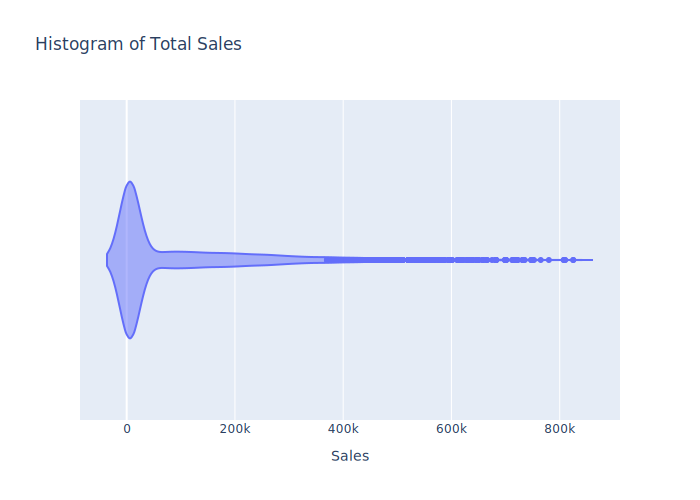

In [24]:
px.violin(adidas, x='Sales', title='Histogram of Total Sales')

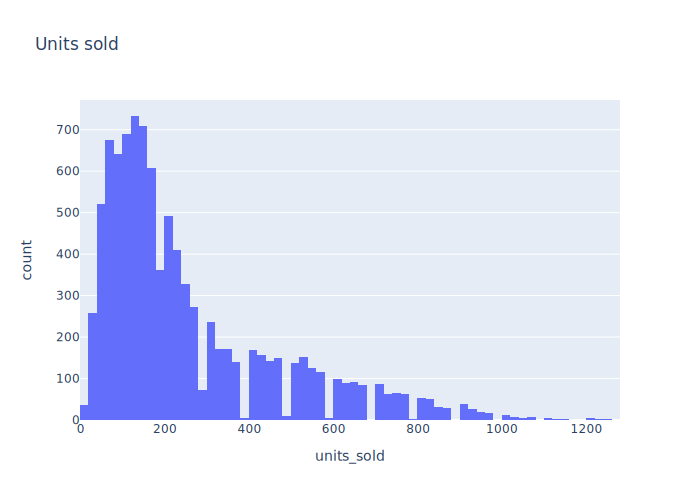

In [25]:
px.histogram(adidas, x='units_sold', title='Units sold')

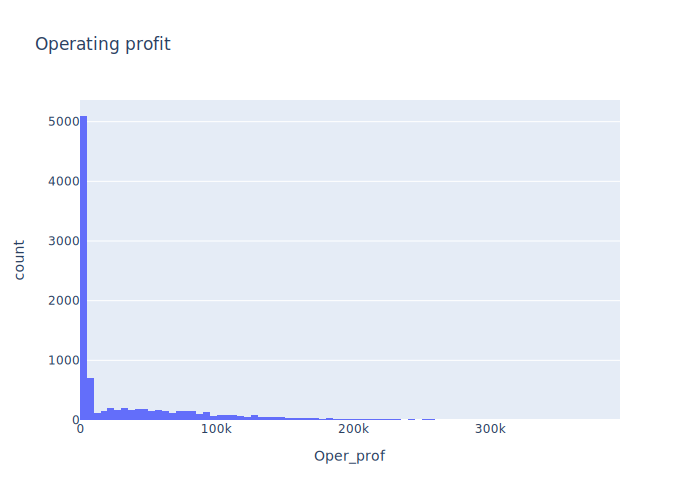

In [26]:
px.histogram(adidas, x='Oper_prof', title='Operating profit')

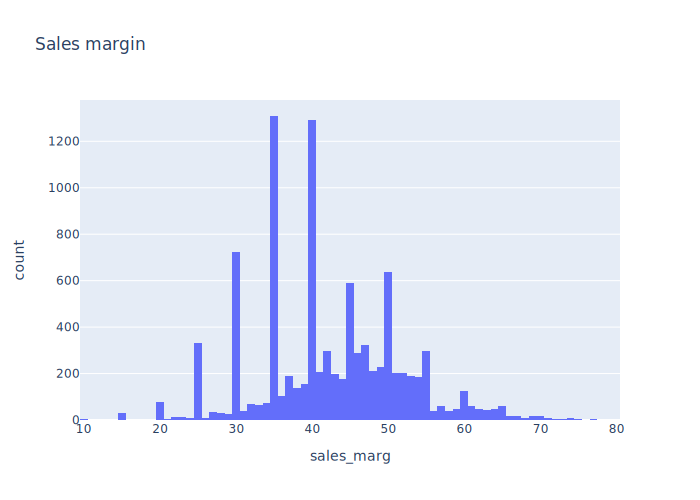

In [27]:
px.histogram(adidas, x='sales_marg', title='Sales margin')

#### Total sales analysis across regions and product

In [28]:
# Performing the aggregations in a single step
aggregated_data = adidas.groupby(['Region', 'Product']).agg({
    'Oper_prof': 'mean',  # Average Operating Profit
    'sales_marg': 'mean',  # Average Operating Margin
    'Sales': 'sum'         # Total Sales Sum
}).reset_index()

# Renaming the columns for clarity
aggregated_data.columns = ['Region', 'Product', 'Avg_Operating_Profit', 
                           'Avg_Operating_Margin', 'SUM_Sales']

aggregated_data

,Region,Product,Avg_Operating_Profit,Avg_Operating_Margin,SUM_Sales
0,Midwest,Men's Apparel,23181.21,45.09,18125661
1,Midwest,Men's Athletic Footwear,23739.83,40.50,21305539
2,Midwest,Men's Street Footwear,48068.52,44.21,38322810
3,Midwest,Women's Apparel,39503.47,49.27,28206383
4,Midwest,Women's Athletic Footwear,16376.26,41.84,13595168
5,Midwest,Women's Street Footwear,18608.00,40.19,16244898
6,Northeast,Men's Apparel,20609.99,36.70,25744412
7,Northeast,Men's Athletic Footwear,25885.60,41.64,28874237
8,Northeast,Men's Street Footwear,53930.16,46.08,51025024
9,Northeast,Women's Apparel,34088.95,41.57,37543083


#### Total sales across regions visualized

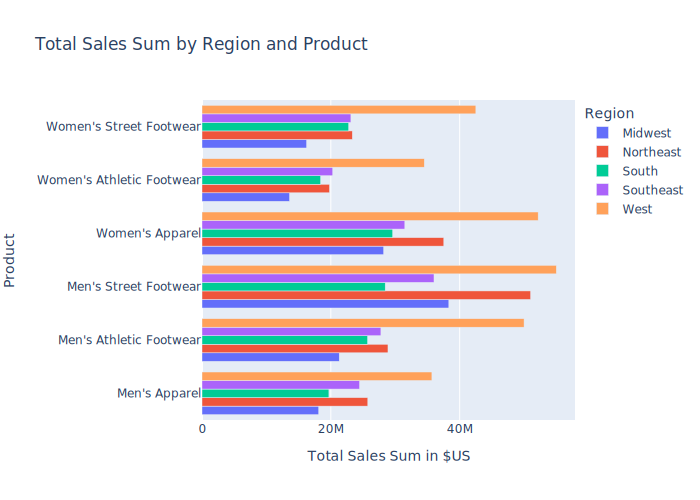

In [29]:
fig = px.bar(aggregated_data, 
             x='SUM_Sales', 
             y='Product', 
             color='Region', 
             barmode='group',
             title='Total Sales Sum by Region and Product',
             labels={'Total Sales Sum': 'Total Sales Sum', 'Product': 'Product'},
             orientation='h')
fig.update_layout(
    xaxis_title='Total Sales Sum in $US',
    yaxis_title='Product',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Total Sales Sum by Region and Product
- Men's Street Footwear and Women's Apparel show the highest sales sums across almost all regions, suggesting they are popular or well-marketed products.
- The West region shows the highest sales sums for nearly all product categories, indicating a larger market size or more effective sales strategies in that region.

#### Average Operating profit across region

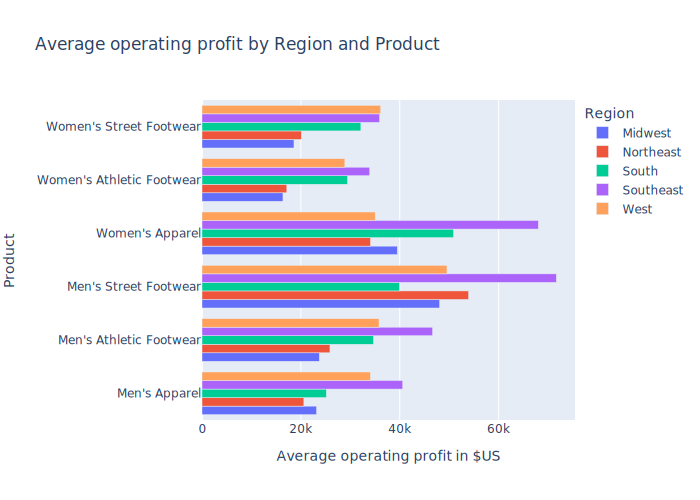

In [30]:
fig = px.bar(aggregated_data, 
             x='Avg_Operating_Profit', 
             y='Product', 
             color='Region', 
             barmode='group',
             title='Average operating profit by Region and Product',
             orientation='h')
fig.update_layout(
    xaxis_title='Average operating profit in $US',
    yaxis_title='Product',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Average Operating Profit by Region and Product
- Men's Street Footwear has notably higher average operating profits in some regions, indicating this category could be a significant contributor to absolute profit.
- The West region seems to consistently have higher operating profits across most product categories, possibly indicating higher sales volumes or better cost management.

#### Average operating margin across regions

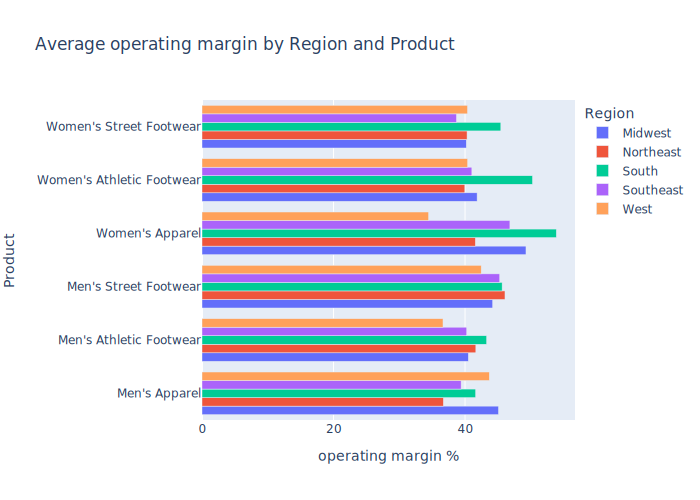

In [31]:
fig = px.bar(aggregated_data, 
             x='Avg_Operating_Margin', 
             y='Product', 
             color='Region', 
             barmode='group',
             title='Average operating margin by Region and Product',
             orientation='h')
fig.update_layout(
    xaxis_title='operating margin %',
    yaxis_title='Product',
    legend_title='Region'
)
# Showing the plot
fig.show()

#### Average Operating Margin by Region and Product
- The operating margins are relatively consistent across regions for the same product categories.
- Women's Street Footwear and Women's Athletic Footwear appear to have higher operating margins compared to other categories, suggesting they might be more profitable relative to their sales.

### Comparing regions by sales method frequency

#### Hypothesis Test for Sales Across Regions
- Question : Are there are significant differences in the average sales across different regions? 
- Method: ANOVA (Analysis of Variance) test. The ANOVA test will assess whether the observed differences in sales averages across regions are statistically significant, or if they could have arisen by chance.
#### Null Hypothesis (H_0)
The null hypothesis states that there is no significant variance in the sales averages across the different regions. 
#### Alternative Hypothesis (H_1)
- The alternative hypothesis suggests that at least one region has a significantly different average total sales compared to the others. 

#### alpha = 0.05

In [32]:
# aggregate total sales based on regions to prepare for the anova tests
northeast = adidas[adidas['Region'] == 'Northeast']['Sales']
south = adidas[adidas['Region'] == 'South']['Sales']
west = adidas[adidas['Region'] == 'West']['Sales']
midwest = adidas[adidas['Region'] == 'Midwest']['Sales']
southeast = adidas[adidas['Region'] == 'Southeast']['Sales']
alpha = 0.05
# Conduct the ANOVA test 
f_statistic, p_value = stats.f_oneway(northeast, south, west, midwest, southeast)
print(f"The f-stat:{round(f_statistic)} and p_value:{p_value}")
if p_value >= alpha:
    print("Failed to reject the null")
else:
    print("Sufficient evidence to reject the null")

The f-stat:53 and p_value:8.006029266117061e-44
Sufficient evidence to reject the null


#### Observation: 
- Accoding to the ANOVA test, we can state that there is a significant difference between
averages of total sales across the regions. 

In [33]:
cont_table = pd.crosstab(adidas['Region'], adidas['Method'])
p = stats.chi2_contingency(cont_table)[1]
if p >= alpha:
    print("Failed to reject the null")
else:
    print("Sufficient evidence to reject the null")

Sufficient evidence to reject the null


In [34]:
p

3.424713829774489e-228

#### Visualize the contingency table

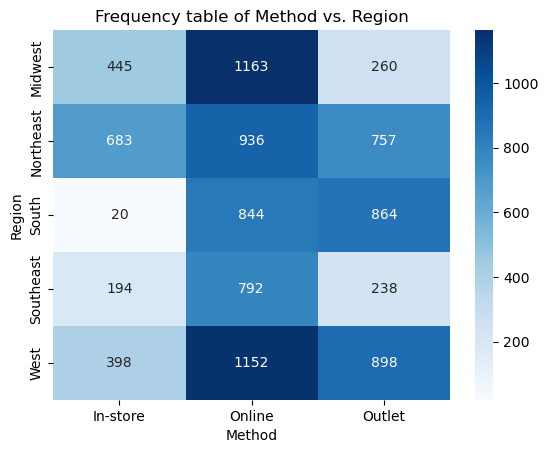

In [40]:
ax = sns.heatmap(cont_table, annot=True, cmap='Blues', fmt='g')
ax.set_title('Frequency table of Method vs. Region')
plt.show()

#### Observations
**Method Preference by Region:**
   - **Midwest:** Dominant preference for Online sales (1165), with low Outlet (262) sales.
   - **Northeast:** More balanced, but still favoring Online (936)
   - **South:** Balanced between  Outlet (864) and Online (844), with the lowest preference for In-store across the U.S. at (20).
   - **Southeast:** Strong preference for Online (792).
   - **West:** Similar to Midwest, high Online (1152) vs. In-store (398).

**Business Implications:** 
   - **Inventory and Marketing:** Align inventory to cater to region-specific sales preferences.
   - **Retail Store Optimization:** Consider store-specific sales/inventory to balance sales quantities based on each region
   - **Online and Outlet Expansion:** Invest in enhancing the online platform and outlet presence in regions showing higher preference for these channels.

## Insights and conclusion

### Insights:

**Product Category Performance**:
- Women's footwear, both street and athletic, tends to have higher operating margins, suggesting efficiency in generating profit relative to sales. This could be due to favorable pricing, lower production costs, or both.
- Men's Street Footwear emerges as a significant contributor to absolute profit in some regions, potentially due to higher price points or effective cost control measures.

**Regional Performance**:
- The West region exhibits consistently higher operating profits across most product categories, potentially indicating higher sales volumes, a larger customer base, or more effective marketing strategies.
- The strong sales of Men's Street Footwear and Women's Apparel across different regions indicate a robust market presence and consumer appeal.

### Conclusions:

- **Marketing**: Focusing marketing efforts on high-margin products like Men's Street Footwear and Women's Footwear could maximize profit margins and sales.
  
- **Regional focus**: The West region's strong performance deserves their continued investment while other regions require analysis to identify and address challenges.

- **Product Development**: High margins in Women's Footwear categories suggest that innovation and development in these lines could be beneficial.

- **Pricing and sales**: Variations in operating margins and profits across categories indicate opportunities for discounts and sales to improve total sales by increasing units sold.

- **Cost Management**: 

The analysis indicates strengths in various regions and product categories, particularly in the West and in categories like Men's Street Footwear and Women's Footwear. Understanding the drivers of success in these areas can guide strategies to enhance performance across the board.